In [1]:
import cvtk

In [2]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import re
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import statsmodels.api as sm
import matplotlib as mpl

In [3]:
from cvtk.cvtk import TemporalFreqs, TiledTemporalFreqs
from cvtk.cov import stack_temporal_covariances
import cvtk.variant_files as vf
from cvtk.gintervals import GenomicIntervals
from cvtk.pca import FreqPCA
from cvtk.plots import rep_plot_pca, correction_diagnostic_plot
from cvtk.utils import integerize
from cvtk.utils import extract_empirical_nulls_diagonals, extract_temporal_cov_diagonals
from cvtk.cov import stack_replicate_covariances, stack_temporal_covs_by_group

/users/r/b/rbrennan/anaconda3/lib/python3.8/site-packages/cvtkpy-0.0.1-py3.8.egg/cvtk/gintervals.py:138: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/users/r/b/rbrennan/anaconda3/lib/python3.8/site-packages/cvtkpy-0.0.1-py3.8.egg/cvtk/gintervals.py:138: SyntaxWarning: "is not" with a literal. Did you mean "!="?


In [4]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.figsize'] = (8.0, 4.0)
mpl.rcParams['figure.dpi'] = 200

In [5]:
np.random.seed(0)

# Data and Annotation Loading

## load in allele frequency data

Here, we only actually have 2 controls. So I needed to duplicate these. This will likely cause problems downstream with the covariance estimations.

In [6]:
SYNC_FILE = '/users/r/b/rbrennan/tonsa_genomics/analysis/atonsa.sync.gz'
sf = vf.SyncFile(SYNC_FILE)
sf

reading file '/users/r/b/rbrennan/tonsa_genomics/analysis/atonsa.sync.gz'...
file '/users/r/b/rbrennan/tonsa_genomics/analysis/atonsa.sync.gz' loaded.
total time to load Sync file: 0.2729906956354777 mins.


VariantFile with 166090 loci and 32 samples.

#### Next, need a file that specifies the genome. in format: scaff name, length. tab delimited.

In [7]:
sf_gi = sf.build_gintervals()
sf_gi.seqlens = dict()
with open('/users/r/b/rbrennan/tonsa_genomics/analysis/tonsa_seqlens.txt') as f:
    for line in f:
        seqid, length = line.strip().split('\t')
        sf_gi.seqlens[seqid] = int(length)

In [8]:
sf_gi

GenomicIntervals — 9473 unique seqids, 166090 features
         GenomicInterval
0  LS387016.1:[102, 103)
1  LS387016.1:[148, 149)
2  LS387016.1:[158, 159)
3  LS387016.1:[162, 163)
4  LS387016.1:[163, 164)
[ 166085 more GenomicIntervals ]

## Study Design

In [9]:
RAW_DESIGN_FILE = '/users/r/b/rbrennan/tonsa_genomics/analysis/tonsa_design.csv'
sample_names = pd.read_csv(RAW_DESIGN_FILE)
#sample_re = re.compile(r"(?P<species>Dsim)_(?P<pop>Fl)_(?P<selection>Base|Hot)_(F(?P<gen>\d+)_)?(?P<rep>\d+)")
#sample_info = [{'name':d, **re.match(sample_re, d).groupdict()} for d in sample_names]
design = sample_names

In [10]:
design

,name,species,pop,selection,gen,rep,id
0,AA_F00_Rep1,Atonsa,LIS,Ambient,0,1,AA-1
1,AA_F00_Rep2,Atonsa,LIS,Ambient,0,2,AA-2
2,AA_F00_Rep3,Atonsa,LIS,Ambient,0,3,AA-3
3,AA_F00_Rep4,Atonsa,LIS,Ambient,0,4,AA-4
4,AA_F25_Rep1,Atonsa,LIS,Ambient,25,1,AA-1
5,AA_F25_Rep2,Atonsa,LIS,Ambient,25,2,AA-2
6,AA_F25_Rep3,Atonsa,LIS,Ambient,25,3,AA-3
7,AA_F25_Rep4,Atonsa,LIS,Ambient,25,4,AA-4
8,AA_F00_Rep1,Atonsa,LIS,Acidic,0,1,AH-1
9,AA_F00_Rep2,Atonsa,LIS,Acidic,0,2,AH-2


Our TemporalFreqs() and TiledTemporalFreqs() objects take a list of tuples (replicate, timepoint), which we create via the design DataFrame:

In [11]:
samples = design[['id', 'gen']].copy().values.tolist()

#np.shape(samples)
#samples = [(t, r) for t, r in (design['id'].values, design['gen'].values)]
#samples = design['id','gen'].tolist()
#print(design['id'].values)
#print(design['gen'].values)
samples

[['AA-1', 0],
 ['AA-2', 0],
 ['AA-3', 0],
 ['AA-4', 0],
 ['AA-1', 25],
 ['AA-2', 25],
 ['AA-3', 25],
 ['AA-4', 25],
 ['AH-1', 0],
 ['AH-2', 0],
 ['AH-3', 0],
 ['AH-4', 0],
 ['AH-1', 25],
 ['AH-2', 25],
 ['AH-3', 25],
 ['AH-4', 25],
 ['HA-1', 0],
 ['HA-2', 0],
 ['HA-3', 0],
 ['HA-4', 0],
 ['HA-1', 25],
 ['HA-2', 25],
 ['HA-3', 25],
 ['HA-4', 25],
 ['HH-1', 0],
 ['HH-2', 0],
 ['HH-3', 0],
 ['HH-4', 0],
 ['HH-1', 25],
 ['HH-2', 25],
 ['HH-3', 25],
 ['HH-4', 25]]

## Import Annotation
These sequence lengths are used for the creation of the tiles.

In [12]:
gff_file = '/users/r/b/rbrennan/tonsa_annotation/gawn/05_results/GCA_900241095.1_Aton1.0_genomic.fa.gff3'
# remove keep seqids, I want to keep all
#keep_seqids = set('2L 2R 3L 3R 4 X'.split())
#dsim = GenomicIntervals.from_gff(gtf_file, filter_type='exon', filter_seqids=keep_seqids, delims=(' ', '; '))
#atonsa = GenomicIntervals.from_gff(gff_file, filter_type='exon')
atonsa = GenomicIntervals.from_gff(gff_file)

In [13]:
atonsa.infer_seqlens()

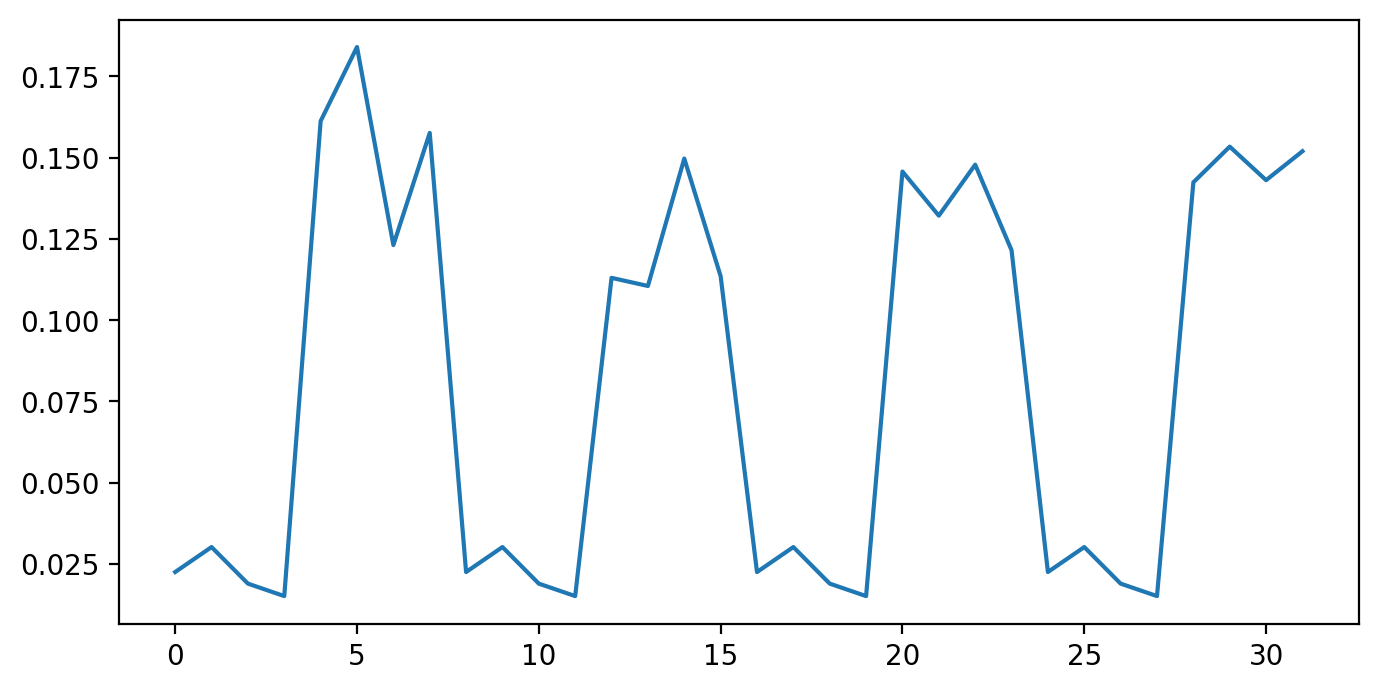

In [14]:
fixed = ((sf.freqs == 0.) | (sf.freqs == 1.))
# what percent of sites are fixed/lost through time?
plt.plot(fixed.mean(axis=0))

In [15]:
tile_width = 1e4
tile_width_label = '1e4'
tiles = GenomicIntervals.from_tiles(atonsa.seqlens, width=tile_width, drop_last_tile=False)
#tiles.intervals

In [16]:
d = TiledTemporalFreqs(tiles, freqs=sf.freqs.T, depths=sf.N.T, diploids=3000, gintervals=sf_gi, samples=samples,
                       share_first=True)

In [17]:
np.amax(d.depths.flatten())

912

In [18]:
np.amin(d.depths.flatten())

40

In [19]:
print(-np.sort(-d.depths.flatten()))

[912 912 912 ...  40  40  40]


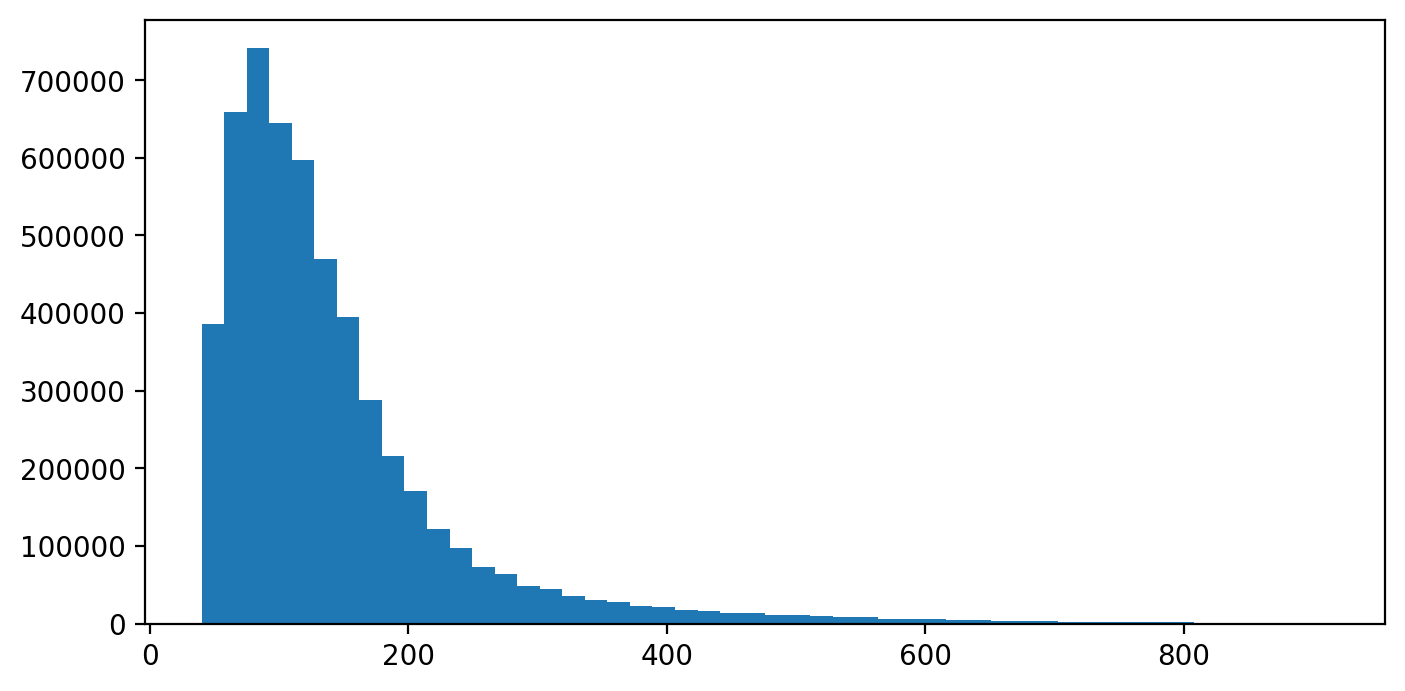

In [20]:
plt.hist(d.depths.flatten(), 50)
plt.show()

In [21]:
d.freqs.shape

(16, 2, 166090)

How many windows and what's the mean and median number of loci per window?

In [22]:
nloci = np.array([len(x) for x in d.tile_indices])

d_noempty = [ele for ele in d.tile_indices if ele != []]
print(len(d_noempty))
print(len(d.tile_indices))

print(f"mean number of loci: {nloci.mean()}")
print(f"median number of loci: {np.median(nloci)}")

9127
42972
mean number of loci: 3.3856231965000467
median number of loci: 0.0


## Genome-wide Covariances

In [23]:
gw_covs = d.calc_cov(use_masked=True, standardize=True)

In [24]:
gw_covs.shape

(16, 16)

In [25]:
stack_temporal_covariances(gw_covs, d.R, d.T).mean(axis=2)

array([[0.04441293]])

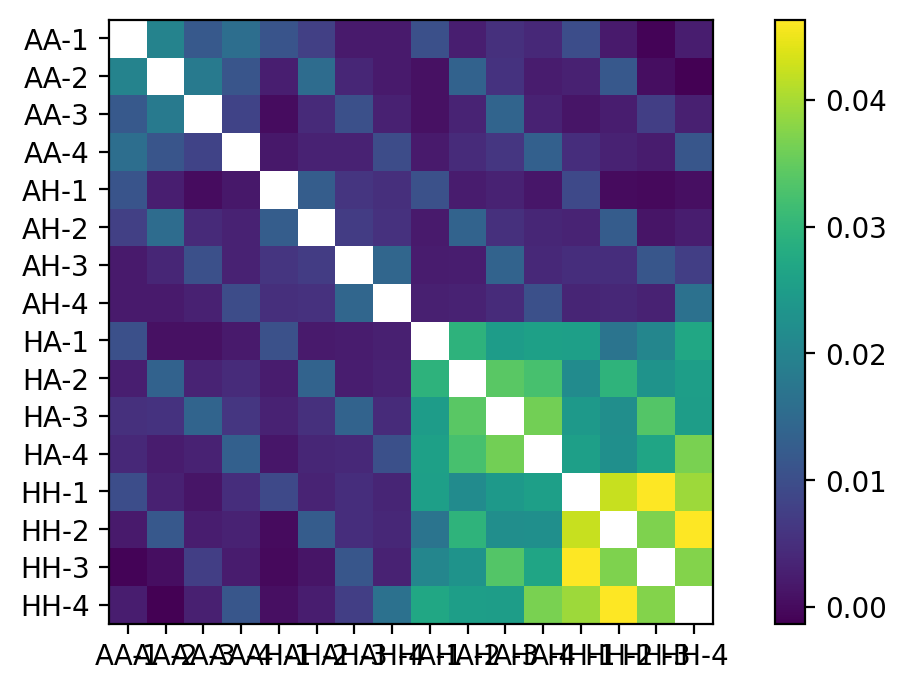

In [26]:
np.fill_diagonal(gw_covs, np.nan)
fig, ax = plt.subplots()
ax.imshow(gw_covs)
img1 = ax.imshow(gw_covs)
fig.colorbar(img1, ax=ax)
sample_names = ['AA-1', 'AA-2', 'AA-3', 'AA-4', 'AH-1', 'AH-2', 'AH-3', 'AH-4', 'HA-1', 'HA-2', 'HA-3', 'HA-4', 'HH-1', 'HH-2', 'HH-3', 'HH-4' ]
ax.set_xticklabels(sample_names)
ax.set_yticklabels(sample_names)
#print( design['name'])
ax.set_xticks(np.arange(len(sample_names)))
ax.set_yticks(np.arange(len(sample_names)))
plt.show()

## Filter windows

As this currently stands, it is filtering based on scaffold id. So we're left with many empty windows.

Instead, can I filter based on the windows that have nan, from the windowed analysis

In [20]:
def unique_shared(cov):
    shared = (cov[4,5] + cov[4,6] + cov[4,7] + cov[5,6] + cov[5,7] + cov[6,7])/6  
    lab = (cov[0,4] + cov[0,5] + cov[0,6] + cov[0,7] + cov[1,4] + cov[1,5] + cov[1,6] + cov[1,7] + cov[2,4] + cov[2,5] + cov[2,6] + cov[2,7] + cov[3,4] + cov[3,5] + cov[3,6] + cov[3,7])/16
    total = (cov[4,4] + cov[5,5] + cov[6,6] + cov[7,7])/4
    #selection = (shared - lab)
    return shared, lab, total

windowed_covs = d.calc_cov_by_tile()
windowed_stats = np.array([unique_shared(win) for win in windowed_covs])
#keep_index = []
#keep_index, keep_win = [windowed_covs for idx, i in enumerate(windowed_covs) if ~np.isnan(windowed_covs[i]).any() and ~np.isinf(windowed_covs[i]).any()]
#windowed_covs_narm = [windowed_covs for windowed_covs in windowed_covs if ~np.isnan(windowed_covs).any() and ~np.isinf(windowed_covs).any()]

In [25]:
#keep_index, keep_win = [i in windowed_covs for i in len(windowed_covs) if ~np.isnan(windowed_covs[i]).any() and ~np.isinf(windowed_covs[i]).any()]
#windowed_covs_narm = [windowed_covs for windowed_covs in windowed_covs if ~np.isnan(windowed_covs).any() and ~np.isinf(windowed_covs).any()]
keep_idx = []
for i in range(len(windowed_covs)):
    if ~np.isnan(windowed_covs[i]).any() and ~np.isinf(windowed_covs[i]).any():
        keep_idx.append(i)

In [46]:
type(d.tiles)

cvtk.gintervals.GenomicIntervals

In [26]:
len(keep_idx)

9073

In [ ]:
gw_covs_cis = d.bootstrap_cov(B=1000, progress_bar=True, keep_seqids=keep_seqids,
                              average_replicates=False, use_masked=True, ci_method="percentile")

In [27]:
#d.tile_df['uniqid'] = d.tile_df['seqid'] + "_" + d.tile_df['midpoint'].astype(str)

# get chrs above 10kb
x2={s:v for s,v in d.tiles.seqlens.items() if v > 10000}

min_sites = 10
keep_seqids = list(set([str(chr) for chr, indices in zip(d.tile_df['seqid'], d.tile_indices) if len(indices) > min_sites]))
#sel_chrs = ['24', '1', '9', '15']
#sel_chrs = ['24']
sel_chrs = []
keep_seqids = [chr for chr in keep_seqids if chr not in sel_chrs]
print(len(keep_seqids))

keep_seqids = set(keep_seqids).intersection(set(x2.keys()))

print(len(keep_seqids))

print(len(d.tile_indices))

4614
1737
42972


In [28]:
exclude_seqids = list(set(d.gintervals.keys()) - set(keep_seqids))
#len(exclude_seqids)
len(keep_seqids)

1737

In [29]:
## Bootstrap whole covaraince matrix.

In [30]:
x=[y for y in d.tiles.seqlens.values() if y < 50000]
x2={s:v for s,v in d.tiles.seqlens.items() if v > 10000}
# x2.keys()


(array([3.358e+03, 1.420e+03, 6.570e+02, 3.340e+02, 1.800e+02, 1.110e+02,
        6.500e+01, 4.000e+01, 2.700e+01, 1.100e+01, 9.000e+00, 4.000e+00,
        6.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 1.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([ 10001. ,  15437.6,  20874.2,  26310.8,  31747.4,  37184. ,
         42620.6,  48057.2,  53493.8,  58930.4,  64367. ,  69803.6,
         75240.2,  80676.8,  86113.4,  91550. ,  96986.6, 102423.2,
        107859.8, 113296.4, 118733. , 124169.6, 129606.2, 135042.8,
        140479.4, 145916. , 151352.6, 156789.2, 162225.8, 167662.4,
        173099. ]),
 <a list of 30 Patch objects>)

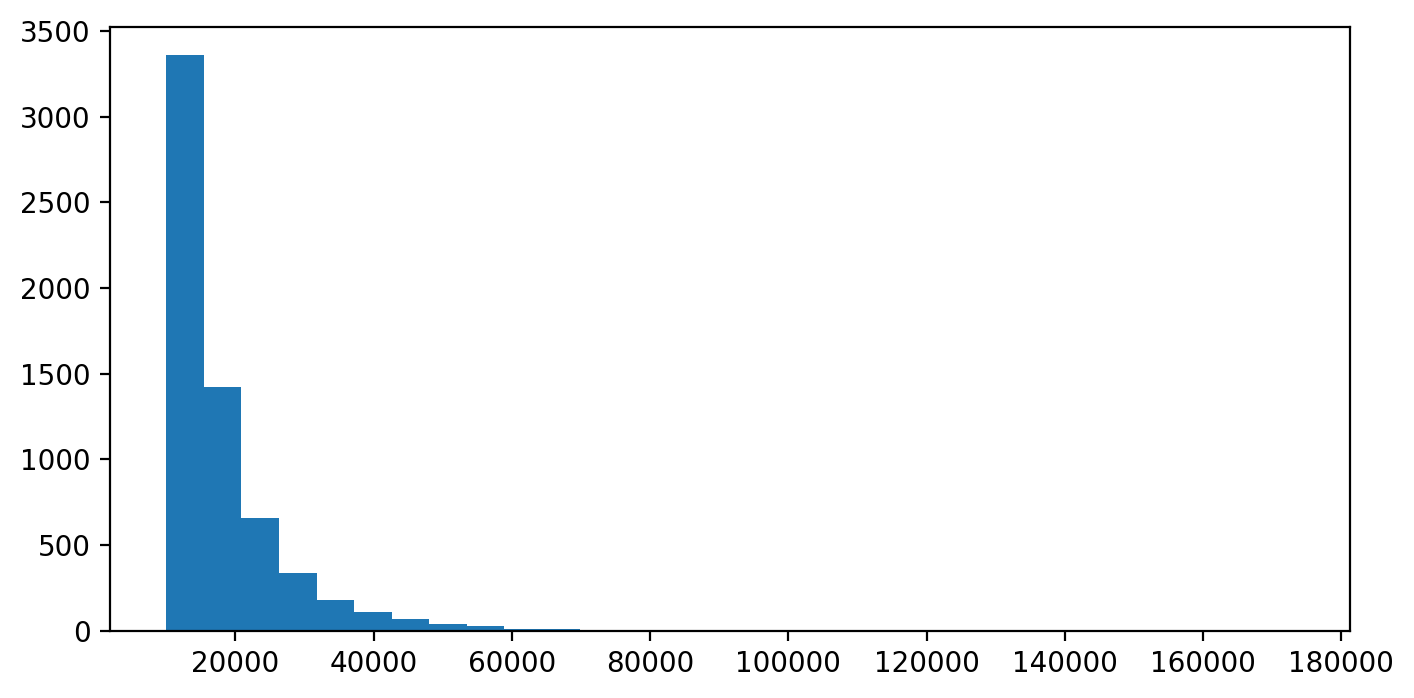

In [31]:
plt.hist(x2.values(), bins=30)

In [32]:
# keep_seqids was a set. need to convert
keep_seqids=list(keep_seqids)

In [33]:
gw_covs_cis = d.bootstrap_cov(B=1000, progress_bar=True, keep_seqids=keep_seqids,
                              average_replicates=False, use_masked=True)

/users/r/b/rbrennan/anaconda3/lib/python3.8/site-packages/cvtkpy-0.0.1-py3.8.egg/cvtk/cov.py:284: RuntimeWarning: Mean of empty slice
/users/r/b/rbrennan/anaconda3/lib/python3.8/site-packages/cvtkpy-0.0.1-py3.8.egg/cvtk/cov.py:345: RuntimeWarning: Mean of empty slice


In [34]:
len(d.tiles)

42972

In [35]:
gw_covs_cis[:,0,0]

array([0.05511741, 0.05465355, 0.06319436])

In [36]:
# try ci method of percentile to see if it fixes CI problem, above.
gw_covs_cis = d.bootstrap_cov(B=1000, progress_bar=True, keep_seqids=keep_seqids,
                              average_replicates=False, use_masked=True, ci_method="percentile")

In [37]:
gw_covs_cis[:,0,0]

array([0.04605288, 0.05465355, 0.05455441])

In [38]:
# get the bootstrap vals
gw_covs_cis = d.bootstrap_cov(B=1000, progress_bar=True, keep_seqids=keep_seqids,
                              average_replicates=False, use_masked=True,
                             return_straps=True)

(array([ 10.,  28., 101., 199., 279., 186., 120.,  64.,  10.,   3.]),
 array([0.01627519, 0.01779724, 0.01931929, 0.02084134, 0.02236339,
        0.02388544, 0.02540749, 0.02692955, 0.0284516 , 0.02997365,
        0.0314957 ]),
 <a list of 10 Patch objects>)

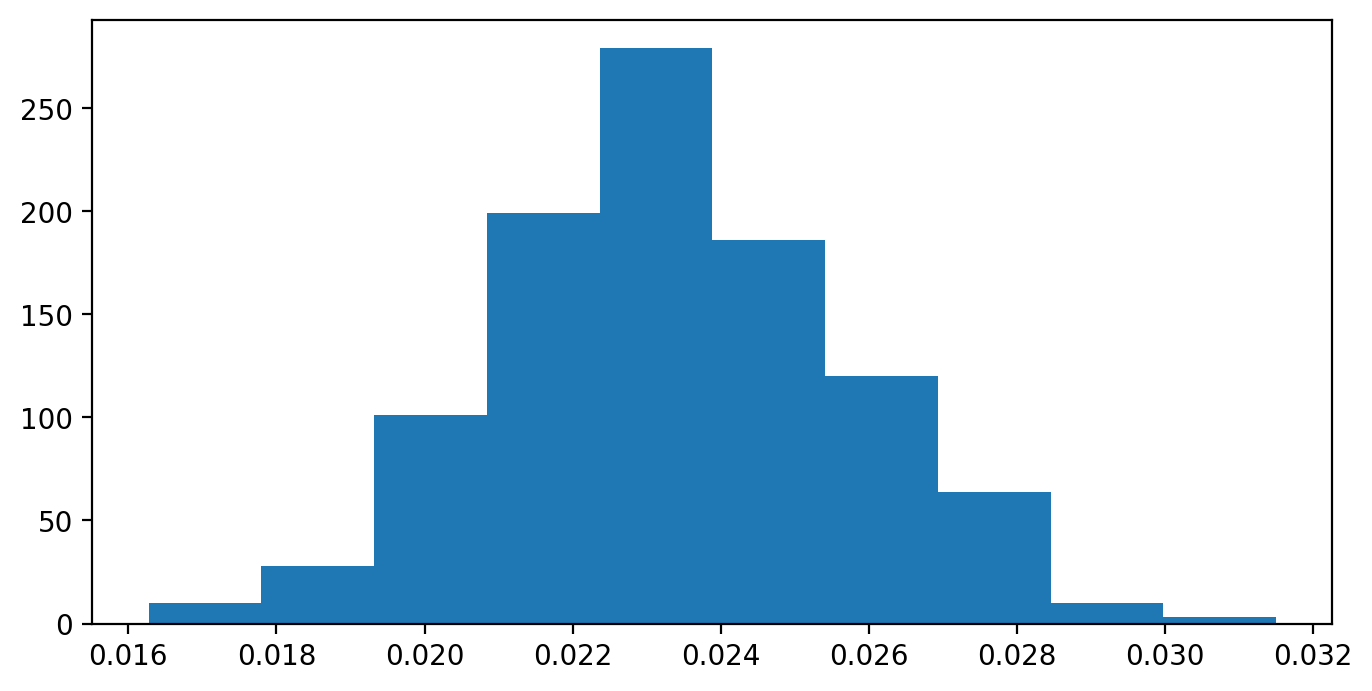

In [39]:
plt.hist(gw_covs_cis[:,10,15])

<ipython-input-40-d3cc3981c7ef>:10: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  markerline, stemline, baseline, = plt.stem(all_labels, mean,linefmt='k--', bottom = -0.01)


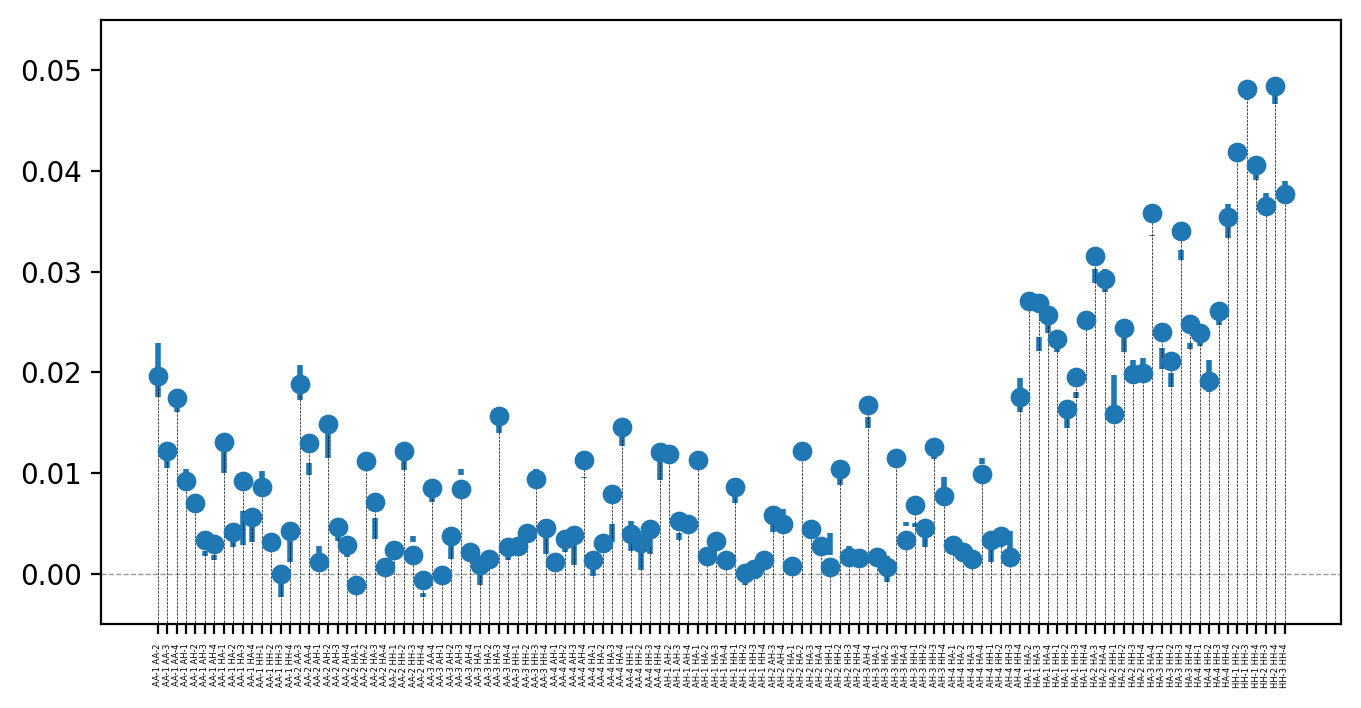

In [40]:

def rep_cov_plot(cis, labels=''):
    rows, cols = np.triu_indices(cis.shape[1], k=1)
    lower, mean, upper = [cis[i, rows, cols].ravel() for i in np.arange(3)]
    all_labels = [labels[i] + " " + labels[j] for i, j in zip(rows, cols)]
    lower, upper = mean-lower, upper-mean
    bounds = np.stack([lower, upper])
    plt.errorbar(all_labels, mean, yerr=bounds, capsize=0, fmt='o', linewidth=1.5, elinewidth=2)
    plt.axhline(y=0, c='0.6', linewidth=0.5, zorder=-1, linestyle='--')
    plt.xticks(rotation='vertical',fontsize=3)
    markerline, stemline, baseline, = plt.stem(all_labels, mean,linefmt='k--', bottom = -0.01)
    plt.setp(stemline, linewidth = 0.25)
    plt.setp(baseline, 'linewidth', 0)
    plt.ylim([-0.005, 0.055])


sample_names = ['AA-1', 'AA-2', 'AA-3', 'AA-4', 'AH-1', 'AH-2', 'AH-3', 'AH-4', 'HA-1', 'HA-2', 'HA-3', 'HA-4', 'HH-1', 'HH-2', 'HH-3', 'HH-4' ]

rep_cov_plot(gw_covs_cis, sample_names)

In [41]:
# print(gw_covs_cis)

### PCA

[2.44126727e-01 1.19616623e-01 7.97080777e-02 6.65235135e-02
 5.13728763e-02 4.79454608e-02 4.10488356e-02 4.07896081e-02
 3.64815682e-02 3.55398993e-02 3.36821616e-02 3.27103153e-02
 3.03788341e-02 2.55850258e-02 2.52654196e-02 2.44963441e-02
 2.27156502e-02 2.19216985e-02 2.00913615e-02 7.12557156e-30
 9.35461306e-31 1.36873250e-31 3.47585762e-32 1.05895176e-32
 1.09961019e-33 1.09961019e-33 1.09961019e-33 1.09961019e-33
 1.09961019e-33 1.09961019e-33 1.09961019e-33 2.64758569e-34]


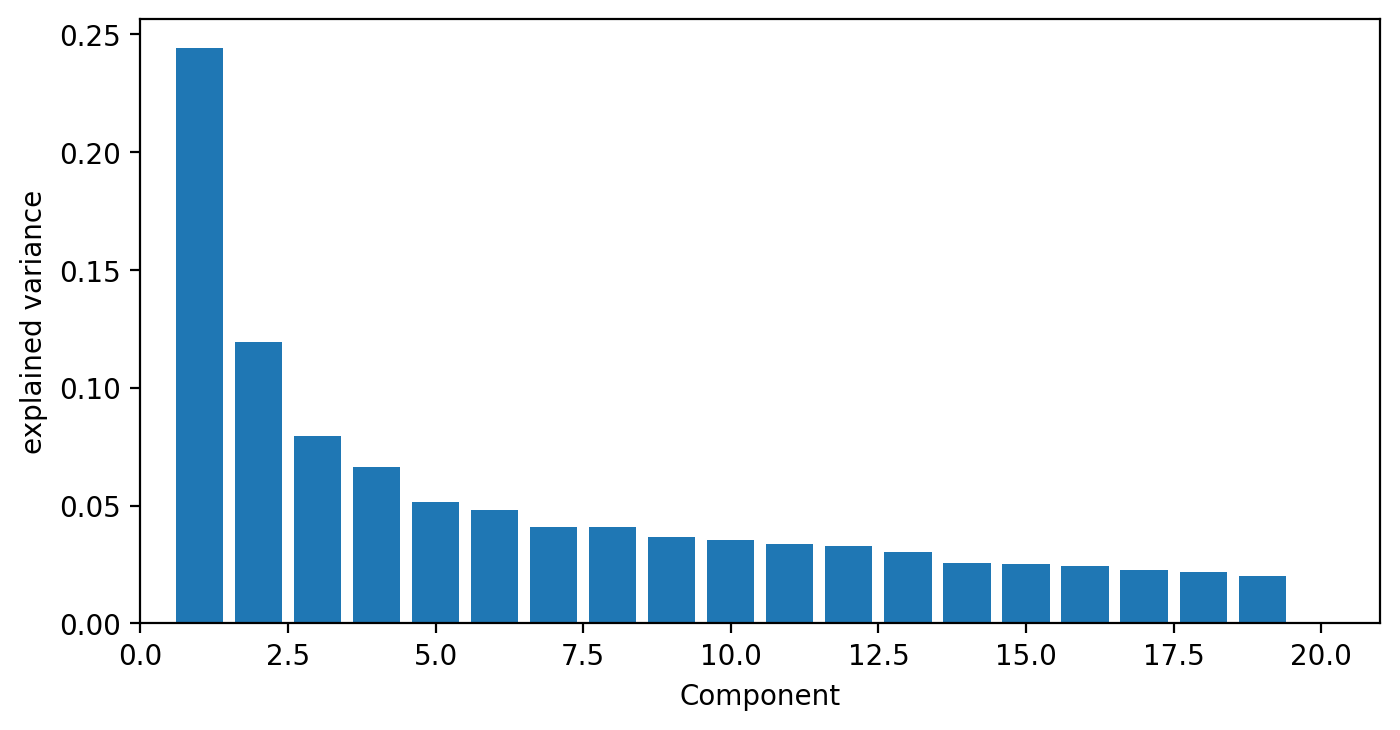

In [42]:
pca = FreqPCA(sf.freqs)
pc_df= pca.to_df()
# add in the sample info:
pc_df[['rep', 'gen', 'id', 'selection']] = design[['rep', 'gen', 'id', 'selection']]
#pc_df.to_csv('../data/e/pca_df.csv', index=False)


def rep_plot_pca3(df, x=1, y=2, s=300, figsize=None, dpi=None, label=True, cmap=None,
                  fontsize=12, variance=None):
    l1, l2 = f"pc{int(x)}", f"pc{int(y)}"
    pc1, pc2 = df[l1], df[l2]
    gen, rep = df['gen'], df['rep']
    ids = df['id']
    selection = df['selection']
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    groups = df.groupby("selection")
    for name, group in groups:
        ax.scatter(group['pc1'], group['pc2'], label=name)
    #ax.scatter(pc1, pc2, c=selection)
    # plot lines between consecutive generations
    for r in rep.unique():
        this_rep = df[df['rep'] == r]
        ax.plot(this_rep[l1], this_rep[l2], '--', color='0.8', zorder=-1)
    # each marker gets a label, of the current replicate
    label_df = df[[l1, l2, 'rep', 'gen', 'id', 'selection']]
    if label:
        for i, point in label_df.iterrows():
                 ax.text(point['pc1'], point['pc2'], str(point['id']),
                                 horizontalalignment='center',verticalalignment='center', fontsize=fontsize)
    if variance is not None:
        pc1=str('%.2f' % variance[0])
        pc2=str('%.2f' % variance[1])
        ax.set_xlabel(l1.upper()+": "+ pc1 )
        ax.set_ylabel(l2.upper()+": "+ pc2 )
    else:
        ax.set_xlabel(l1.upper())
        ax.set_ylabel(l2.upper())
    ax.legend()
    #plt.tight_layout()
    return fig, ax

explained_variance_ratio = pca.explained_variance / np.sum(pca.explained_variance)
print(explained_variance_ratio)
len(np.cumsum(explained_variance_ratio))
plt.bar(range(1,33),explained_variance_ratio)
plt.xlabel('Component')
plt.ylabel('explained variance')
#plt.ylim(0,1.05)
plt.xlim(0,21);

(<Figure size 1600x800 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc6e9fcaca0>)

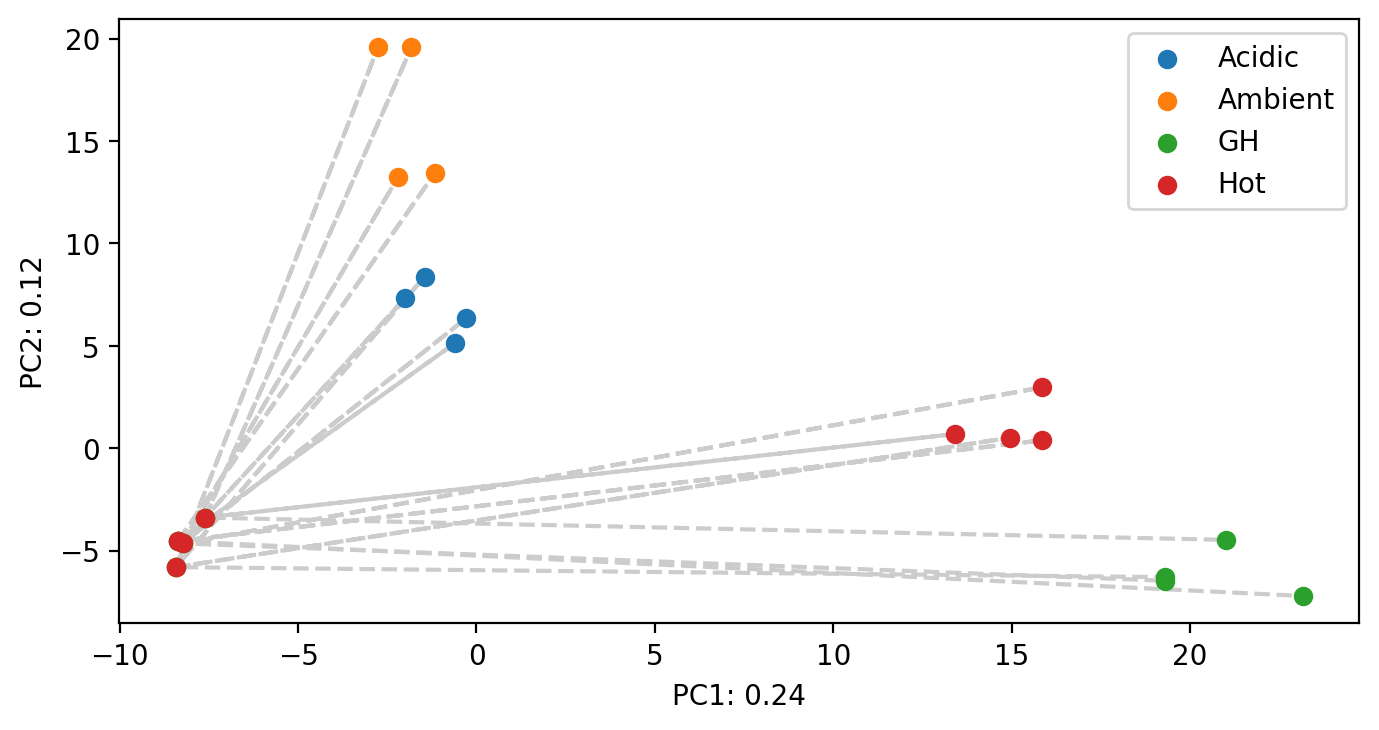

In [43]:
explained_variance_ratio = pca.explained_variance / np.sum(pca.explained_variance)

rep_plot_pca3(pc_df, 1,2, variance=explained_variance_ratio, label=False)

## Bias correction

In [44]:
diagnostics = d.correction_diagnostics(exclude_seqids=exclude_seqids)

/users/r/b/rbrennan/anaconda3/lib/python3.8/site-packages/cvtkpy-0.0.1-py3.8.egg/cvtk/cvtk.py:247: RuntimeWarning: Mean of empty slice.
/users/r/b/rbrennan/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/users/r/b/rbrennan/anaconda3/lib/python3.8/site-packages/cvtkpy-0.0.1-py3.8.egg/cvtk/cvtk.py:261: RuntimeWarning: Mean of empty slice.
/users/r/b/rbrennan/anaconda3/lib/python3.8/site-packages/cvtkpy-0.0.1-py3.8.egg/cvtk/cov.py:284: RuntimeWarning: Mean of empty slice
/users/r/b/rbrennan/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/users/r/b/rbrennan/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:153: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/users/r/b/rbrennan/anaconda3/lib/python3.8/site-packages/cvtkpy-0.0.1-py3.8.egg/cvtk/cov.py:316

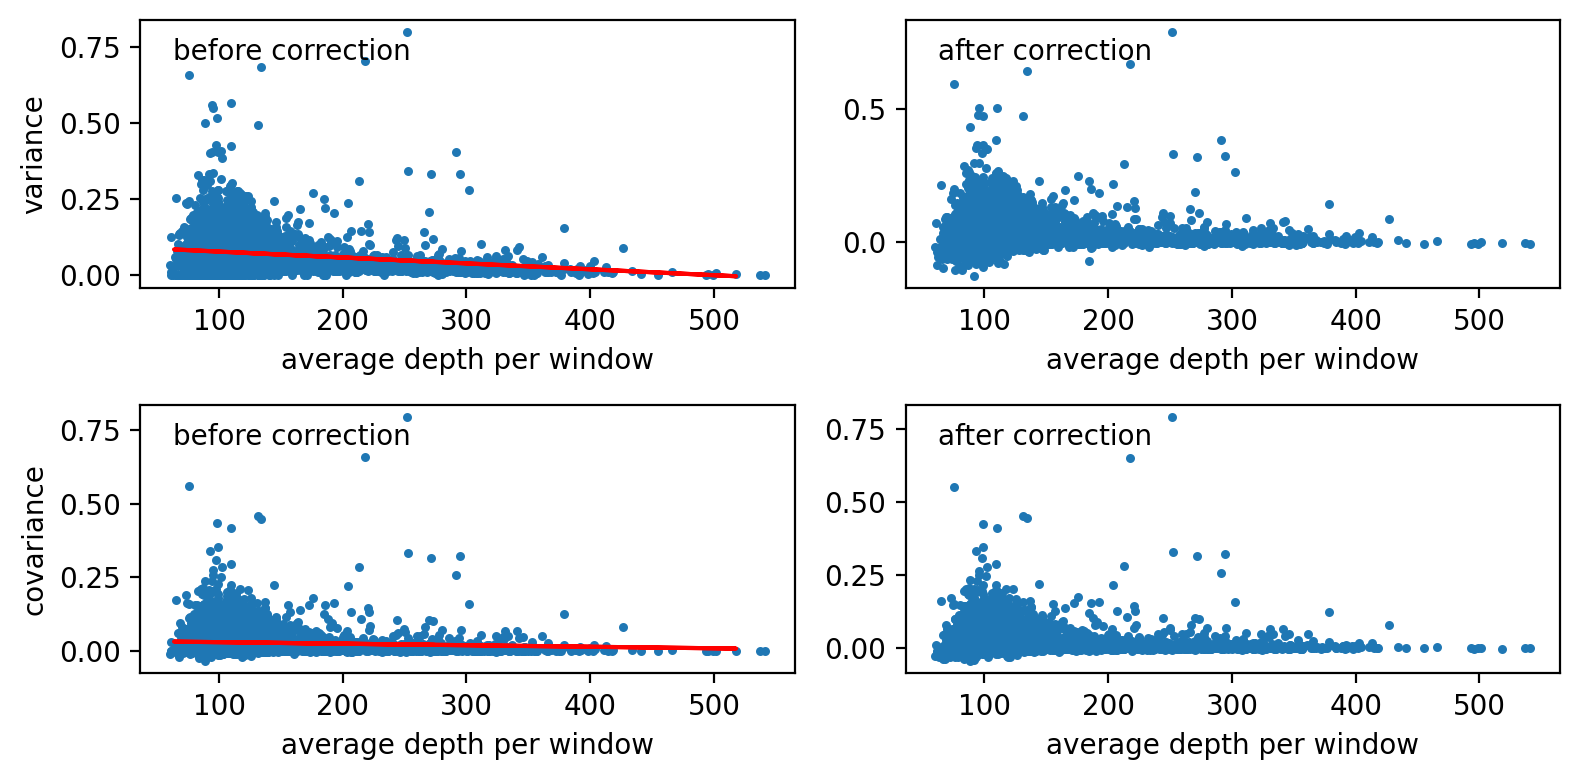

In [45]:
# _ = correction_diagnostic_plot(diagnostics, color=False)
# diagnostic plot from package threw error.
def correction_diagnostic_plot(diag, figsize=None, color=True):
    corr_df, models, xpreds, ypreds = diag
    if figsize is not None:
        fig, ax = plt.subplots(ncols=2, nrows=2, figsize=figsize)
    else:
        fig, ax = plt.subplots(ncols=2, nrows=2)
    labelx, labely = 0.05, 0.85
    before = corr_df[corr_df['correction'] == False]
    after = corr_df[corr_df['correction'] == True]
    if color:
        ax[0, 0].scatter(before['depth'], before['diag'], c=integerize(before['seqid']), s=5)
        ax[0, 1].scatter(before['depth'], after['diag'], c=integerize(before['seqid']), s=5)
    else:
        ax[0, 0].scatter(before['depth'], before['diag'], s=5)
        ax[0, 1].scatter(before['depth'], after['diag'], s=5)
    ax[0, 0].plot(xpreds[False], ypreds[False][0], 'r-')
    ax[0, 1].plot(xpreds[True], ypreds[True][0], 'r-')
    ax[0, 0].annotate('before correction', xy=(labelx, labely), xycoords='axes fraction')
    ax[0, 0].set_ylabel('variance')
    ax[0, 0].set_xlabel('average depth per window')
    ax[0, 1].set_xlabel('average depth per window')
    ax[0, 1].annotate('after correction', xy=(labelx, labely), xycoords='axes fraction')

    ax[1, 0].plot(xpreds[False], ypreds[False][1], 'r-')
    ax[1, 0].annotate('before correction', xy=(labelx, labely), xycoords='axes fraction')
#    ax[1, 0].axhline(y=0, color='99', zorder=1, linestyle='--')
    ax[1, 0].set_ylabel('covariance')
    if color:
        ax[1, 0].scatter(before['depth'], before['offdiag'], c=integerize(before['seqid']),
                         zorder=2, s=5)
        ax[1, 1].scatter(before['depth'], after['offdiag'], c=integerize(before['seqid']),
                         zorder=2, s=5)
    else:
        ax[1, 0].scatter(before['depth'], before['offdiag'], zorder=2, s=5)
        ax[1, 1].scatter(before['depth'], after['offdiag'], zorder=2, s=5)
    ax[1, 1].plot(xpreds[True], ypreds[True][1], 'r-')
    ax[1, 1].annotate('after correction', xy=(labelx, labely), xycoords='axes fraction')
 #   ax[1, 1].axhline(y=0, color='99', zorder=1, linestyle='--')
    ax[1, 0].set_xlabel('average depth per window')
    ax[1, 1].set_xlabel('average depth per window')
    plt.tight_layout()
    return fig, ax

_ = correction_diagnostic_plot(diagnostics, color=False)

## Bootstrap Convergence Correlation

In [46]:
conv_corr = d.convergence_corr()
print(conv_corr)

[[[0.26149409]]]


In [47]:
convergence_corr = d.bootstrap_convergence_corr(B=5000, progress_bar=True)
print(convergence_corr)

/users/r/b/rbrennan/anaconda3/lib/python3.8/site-packages/cvtkpy-0.0.1-py3.8.egg/cvtk/cov.py:284: RuntimeWarning: Mean of empty slice
/users/r/b/rbrennan/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/users/r/b/rbrennan/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:153: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/users/r/b/rbrennan/anaconda3/lib/python3.8/site-packages/cvtkpy-0.0.1-py3.8.egg/cvtk/cov.py:316: RuntimeWarning: Degrees of freedom <= 0 for slice
/users/r/b/rbrennan/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/users/r/b/rbrennan/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/users/r/b/rbrennan/anaconda3/lib/python3.8/sit


[[[[0.2652595 ]]]


 [[[0.26149409]]]


 [[[0.29161421]]]]


Convergence Correlation per Comparison

In [48]:
import itertools

In [49]:
#combs = list(itertools.combinations(range(0,16),2))
# just run a couple, to act as example
combs = list(itertools.combinations(range(0,8),2))

outlist = []

for x in combs:
    outlist.append(
                    d.bootstrap_convergence_corr(B=5000, 
                                                 progress_bar=False, subset=(x[0], x[1])))
    print("done with rep", x)

done with rep (0, 1)
done with rep (0, 2)
done with rep (0, 3)
done with rep (0, 4)
done with rep (0, 5)
done with rep (0, 6)
done with rep (0, 7)
done with rep (1, 2)
done with rep (1, 3)
done with rep (1, 4)
done with rep (1, 5)
done with rep (1, 6)
done with rep (1, 7)
done with rep (2, 3)
done with rep (2, 4)
done with rep (2, 5)
done with rep (2, 6)
done with rep (2, 7)
done with rep (3, 4)
done with rep (3, 5)
done with rep (3, 6)
done with rep (3, 7)
done with rep (4, 5)
done with rep (4, 6)
done with rep (4, 7)
done with rep (5, 6)
done with rep (5, 7)
done with rep (6, 7)


In [50]:
combined_conv_corrs = np.stack(outlist).squeeze()
np.savetxt('/users/r/b/rbrennan/tonsa_genomics/scripts/cvtk/combined_conv_corrs.csv', combined_conv_corrs, delimiter=',')

combined_conv_corrs

array([[0.40848862, 0.42393843, 0.44343502],
       [0.28859494, 0.29855789, 0.32775275],
       [0.34990727, 0.36077167, 0.38762698],
       [0.35612261, 0.34100698, 0.39591316],
       [0.2006899 , 0.20590813, 0.24515631],
       [0.05819027, 0.05868335, 0.11241566],
       [0.07003554, 0.0667089 , 0.12263289],
       [0.43671286, 0.43906446, 0.47305572],
       [0.24368413, 0.2497477 , 0.29067655],
       [0.09075725, 0.08160665, 0.14438492],
       [0.40924377, 0.40254485, 0.45279262],
       [0.10951811, 0.1006511 , 0.16941683],
       [0.06705104, 0.0634217 , 0.12300464],
       [0.21241868, 0.21254349, 0.26106662],
       [0.0184552 , 0.01050904, 0.07728804],
       [0.14437048, 0.13349416, 0.19941827],
       [0.35971054, 0.3279471 , 0.40860524],
       [0.11698622, 0.10686799, 0.17886637],
       [0.07167964, 0.05910477, 0.1311364 ],
       [0.09959136, 0.0923815 , 0.15503395],
       [0.10499441, 0.09287549, 0.16398125],
       [0.3286375 , 0.30572504, 0.37868156],
       [0.

<ipython-input-51-b882f8c043b7>:21: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  plt.stem(all_labels, mean, linefmt = ':')


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27],
 <a list of 28 Text major ticklabel objects>)

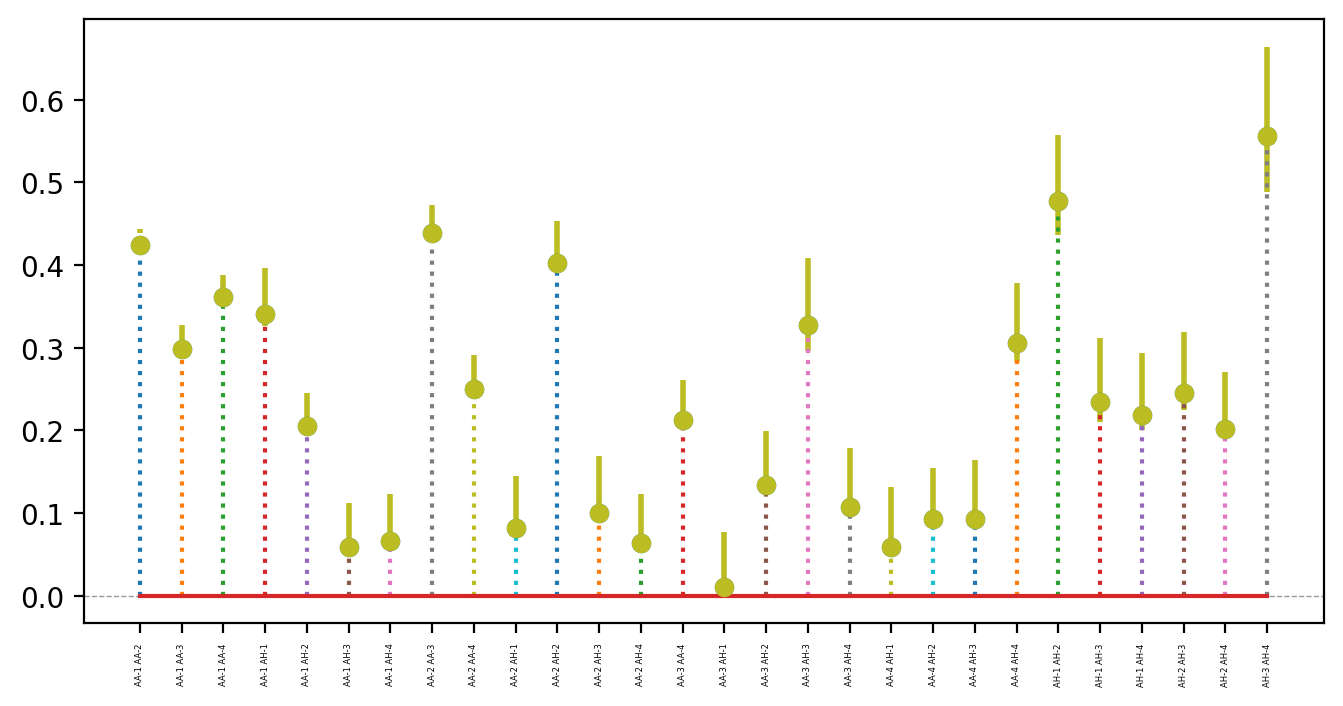

In [51]:
#plt.plot([1, 2, 3, 4])
#plt.ylabel('some numbers')
#plt.show()
    
mean = np.array([x[1] for x in combined_conv_corrs])
lower = np.array([x[0] for x in combined_conv_corrs])
upper = np.array([x[2] for x in combined_conv_corrs])

#print(lower)
#print(mean)
#print(upper)
#upper

all_labels = [sample_names[i[0]] + " " + sample_names[i[1]] for i in combs]

lower_bound, upper_bound = lower-mean, upper-mean

bounds = [lower_bound, upper_bound]
#print(bounds)
#fig = plt.figure()
plt.stem(all_labels, mean, linefmt = ':')

plt.errorbar(all_labels, mean, yerr=bounds, capsize=0, fmt='o', linewidth=1, elinewidth=2)
plt.axhline(y=0, c='0.6', linewidth=0.5, zorder=-1, linestyle='--')
plt.xticks(rotation='vertical',fontsize=3)

#locs, labels = plt.xticks()
#print(labels)
#plt.axvline(x=locs, c='0.4', linewidth=0.5, linestyle="--")


#sample_names = ['AA-1', 'AA-2', 'AA-3', 'AA-4', 'AH-1', 'AH-2', 'AH-3', 'AH-4', 'HA-1', 'HA-2', 'HA-3', 'HA-4', 'HH-1', 'HH-2', 'HH-3', 'HH-4' ]

#rep_cov_plot(gw_covs_cis, sample_names)

## Genome-wide G
Averaging across replicates:

In [21]:
g_averep = d.calc_G(average_replicates=True)
with open('g_averep_AA.npy', 'wb') as f:
    np.save(f, g_averep)

Not averaging across replicates:

In [22]:
g = d.calc_G(average_replicates=False)
with open('g.npy', 'wb') as f:
    np.save(f, g)

### Partitioning Variance into Shared and Unique Contributions

First, total variance to af change

In [17]:
gw_vars = d.calc_var()
gw_covs = d.calc_cov()

print((gw_vars))

ambient = (gw_covs[0,1] + gw_covs[0,2] + gw_covs[0,3] + gw_covs[1,2] + gw_covs[1,3] + gw_covs[2,3])/6  
acidic  = (gw_covs[4,5] + gw_covs[4,6] + gw_covs[4,7] + gw_covs[5,6] + gw_covs[5,7] + gw_covs[6,7])/6  
warm    = (gw_covs[8,9] + gw_covs[8,10] + gw_covs[8,11] + gw_covs[9,10] + gw_covs[9,11] + gw_covs[10,11])/6  
GH      = (gw_covs[12,13] + gw_covs[12,14] + gw_covs[12,15] + gw_covs[13,14] + gw_covs[13,15] + gw_covs[14,15])/6  

print(ambient)
print(acidic)
print(warm)
print(GH)

ambient1 = (gw_vars[0] + gw_vars[1] + gw_vars[2] + gw_vars[3])/4
acidic1  = (gw_vars[4] + gw_vars[5] + gw_vars[6] + gw_vars[7])/4
warm1    = (gw_vars[8] + gw_vars[9] + gw_vars[10] + gw_vars[11])/4
GH1      = (gw_vars[12] + gw_vars[13] + gw_vars[14] + gw_vars[15])/4  

print(ambient1)
print(acidic1)
print(warm1)
print(GH1)

#then estimate Ne with:

#(V(Pt-P0)/P0(1-P0))=t/2Ne
# where the left side of this is equal to the var estimate, above.
print('Ambient Ne:', 25/(2*ambient1))
print('Acidic Ne:', 25/(2*acidic1))
print('Warm Ne:', 25/(2*warm1))
print('GH Ne:', 25/(2*GH1))

[0.0536936  0.05614773 0.04301417 0.04971336 0.03049409 0.03849317
 0.03580942 0.03137327 0.0500038  0.05499648 0.06045347 0.05157825
 0.07230234 0.06099619 0.05608655 0.08649747]
0.014297078696959883
0.008490389659079342
0.03052405536188237
0.0415057912635398
0.050642215326101234
0.034042487226098914
0.054257997268931324
0.0689706395938151
Ambient Ne: 246.82964438874856
Acidic Ne: 367.1882115128411
Warm Ne: 230.38078493836383
GH Ne: 181.23653881732207


In [21]:
from cvtk.bootstrap import bootstrap_ci, block_bootstrap_ratio_averages

In [22]:
windowed_covs = d.calc_cov_by_tile()

/users/r/b/rbrennan/anaconda3/lib/python3.8/site-packages/cvtkpy-0.0.1-py3.8.egg/cvtk/cov.py:284: RuntimeWarning: Mean of empty slice
/users/r/b/rbrennan/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/users/r/b/rbrennan/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:153: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/users/r/b/rbrennan/anaconda3/lib/python3.8/site-packages/cvtkpy-0.0.1-py3.8.egg/cvtk/cov.py:316: RuntimeWarning: Degrees of freedom <= 0 for slice
/users/r/b/rbrennan/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/users/r/b/rbrennan/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/users/r/b/rbrennan/anaconda3/lib/python3.8/sit

In [23]:
windowed_stats = np.array([unique_shared(win) for win in windowed_covs])

NameError: name 'unique_shared' is not defined

### shared change due to selection:
    mean(cov between each replicate in that treatment) - mean(cov with ambient control)/(total variance)

In [25]:
# shared change due to Acidic selection

sample_names = ['AA-1', 'AA-2', 'AA-3', 'AA-4', 'AH-1', 'AH-2', 'AH-3', 'AH-4', 'HA-1', 'HA-2', 'HA-3', 'HA-4', 'HH-1', 'HH-2', 'HH-3', 'HH-4' ]
# rows and cols should match sample names, above
gw_covs = d.calc_cov()
gw_covs

shared = (gw_covs[4,5] + gw_covs[4,6] + gw_covs[4,7] + gw_covs[5,6] + gw_covs[5,7] + gw_covs[6,7])/6  
lab = (gw_covs[0,4] + gw_covs[0,5] + gw_covs[0,6] + gw_covs[0,7] + gw_covs[1,4] + gw_covs[1,5] + gw_covs[1,6] + gw_covs[1,7] + gw_covs[2,4] + gw_covs[2,5] + gw_covs[2,6] + gw_covs[2,7] + gw_covs[3,4] + gw_covs[3,5] + gw_covs[3,6] + gw_covs[3,7])/16
total = (gw_covs[4,4] + gw_covs[5,5] + gw_covs[6,6] + gw_covs[7,7])/4

selection = (shared - lab)/total

print('acidic treatment:')
print('shared:', shared/total)
print('lab:', lab/total)
print('total:', total)
print('selection:', selection)


acidic treatment:
shared: 0.3206693862968973
lab: 0.197505313947834
total: 0.026477082072369606
selection: 0.12316407234906328


In [26]:
# need function to bootstrap over
def unique_shared(cov):
    shared = (cov[4,5] + cov[4,6] + cov[4,7] + cov[5,6] + cov[5,7] + cov[6,7])/6  
    lab = (cov[0,4] + cov[0,5] + cov[0,6] + cov[0,7] + cov[1,4] + cov[1,5] + cov[1,6] + cov[1,7] + cov[2,4] + cov[2,5] + cov[2,6] + cov[2,7] + cov[3,4] + cov[3,5] + cov[3,6] + cov[3,7])/16
    total = (cov[4,4] + cov[5,5] + cov[6,6] + cov[7,7])/4
    #selection = (shared - lab)
    return shared, lab, total

shared, lab, total = unique_shared(gw_covs)
print('shared:', shared/total)
print('lab:', lab/total)
#print('selection:', selection/total)

shared: 0.3206693862968973
lab: 0.197505313947834


In [27]:
from cvtk.bootstrap import bootstrap_ci, block_bootstrap_ratio_averages

In [28]:
windowed_covs = d.calc_cov_by_tile()

In [52]:
len(windowed_covs)

42972

In [38]:
windowed_covs_narm = [windowed_covs for windowed_covs in windowed_covs if ~np.isnan(windowed_covs).any() and ~np.isinf(windowed_covs).any()]

In [39]:
len(windowed_covs_narm)

9073

In [40]:
windowed_stats = np.array([unique_shared(win) for win in windowed_covs_narm])
windowed_stats[0]

array([0.00810714, 0.01212723, 0.03056365])

In [50]:
# bootstrap indiv values

B = 1000

# the output from windowed_stats is shared, lab, total

# set up variables outside of loop:
## calc the total variance for ACIDIC,
vars = np.array([(win[4,4] + win[5,5] + win[6,6] + win[7,7])/4 for win in windowed_covs_narm])

# hold output:
shared_straps, lab_straps, selection_straps, total_straps = [], [], [], []

# loop is below here
for b in np.arange(B):
    bidx = np.random.randint(0, len(windowed_covs_narm), len(windowed_covs_narm))
    var_ls = vars[bidx].mean()
    s, l, t = windowed_stats[bidx].mean(axis=0)
    # I want
    shared_straps.append(s/var_ls)
    lab_straps.append(l/var_ls)
    selection_straps.append((s-l)/var_ls)
    total_straps.append(t)

shared: [25.6 32.1 29.8]
0.3206693862968973


(array([  4.,   7.,  53., 136., 224., 285., 169.,  86.,  29.,   7.]),
 array([0.23954805, 0.24661213, 0.25367621, 0.2607403 , 0.26780438,
        0.27486846, 0.28193254, 0.28899662, 0.2960607 , 0.30312478,
        0.31018887]),
 <a list of 10 Patch objects>)

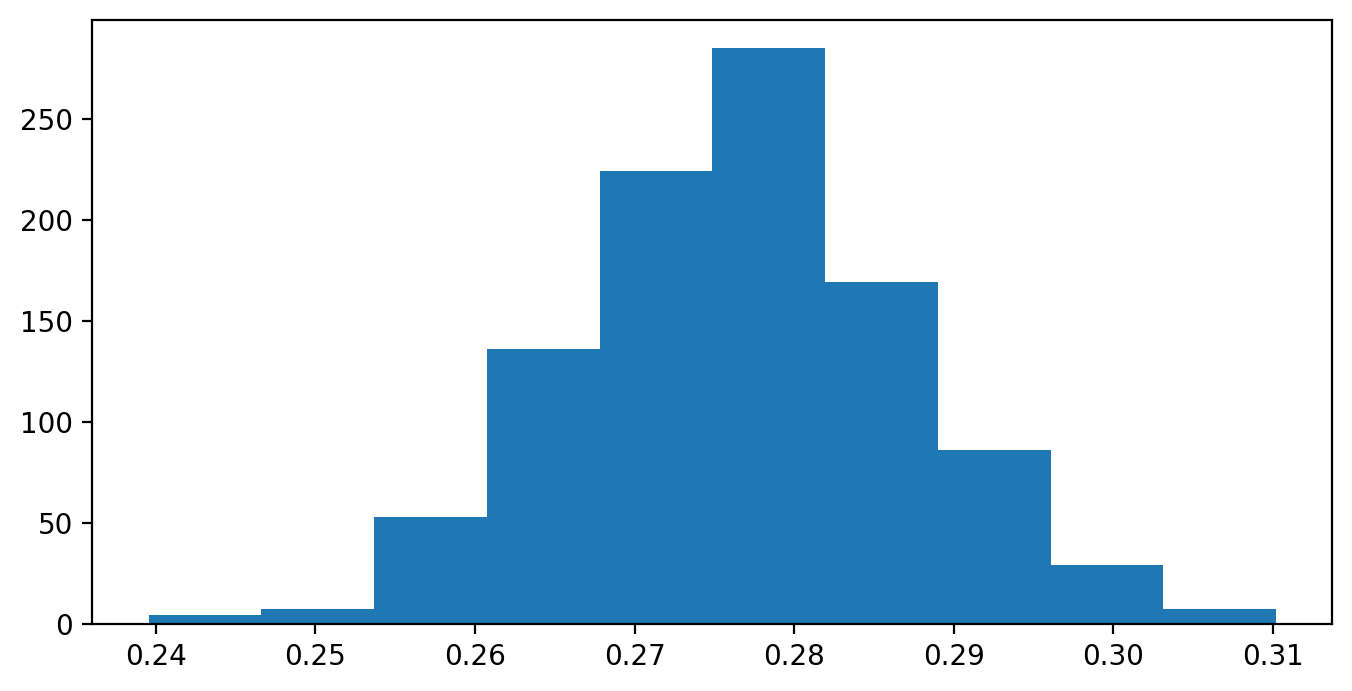

In [51]:
# need total variation:
ls_var = (gw_covs[1,1] + gw_covs[2,2])/2

# also need estimated values from all data:

# then bootstrap

print('shared:', (bootstrap_ci(shared/total, shared_straps, method="percentile") * 100).round(1))
print(shared/total)

plt.hist(shared_straps)

In [86]:
#windowed_stats = np.array([unique_shared(win) for win in windowed_covs_narm])
windowed_stats[bidx]
windowed_stats = np.array([win[0] for win in windowed_stats[bidx]])

SyntaxError: invalid syntax (<ipython-input-86-a5f07b82c965>, line 3)

In [63]:
print(shared_straps)
print(lab_straps)
print(selection_straps)
print(total_straps)

[0.26525427580148325]
[0.39678613382368266]
[-0.1315318580221994]
[0.03056364823571804]


### repeat for GH

In [ ]:
# need function to bootstrap over
def unique_shared(cov):
    shared = (gw_covs[12,13] + gw_covs[12,14] + gw_covs[12,15] + gw_covs[13,14] + gw_covs[13,15] + gw_covs[14,15])/6  
    lab = (cov[0,12] + cov[0,13] + cov[0,14] + cov[0,15] + cov[1,4] + cov[1,5] + cov[1,6] + cov[1,7] + cov[2,4] + cov[2,5] + cov[2,6] + cov[2,7] + cov[3,4] + cov[3,5] + cov[3,6] + cov[3,7])/16
    total = (cov[4,4] + cov[5,5] + cov[6,6] + cov[7,7])/4
    #selection = (shared - lab)
    return shared, lab, total

shared, lab, total = unique_shared(gw_covs)
print('shared:', shared/total)
print('lab:', lab/total)
#print('selection:', selection/total)

windowed_covs = d.calc_cov_by_tile()

windowed_covs_narm = [windowed_covs for windowed_covs in windowed_covs if ~np.isnan(windowed_covs).any()]

print(len(windowed_covs_narm))

windowed_stats = np.array([unique_shared(win) for win in windowed_covs_narm])

# figure out how to calc indiv values

# the output from windowed_stats is shared, lab, total

# set up variables outside of loop:
## calc the total variance for ACIDIC,
vars = np.array([(win[4,4] + win[5,5] + win[6,6] + win[7,7])/4 for win in windowed_covs_narm])

# hold output:
shared_straps, lab_straps, selection_straps, total_straps = [], [], [], []

# loop is below here
# bidx = np.random.randint(0, len(windowed_covs), len(windowed_covs))
bidx = 0
var_ls = vars[bidx]
s, l, t = windowed_stats[bidx, :]
# I want
shared_straps.append(s/var_ls)
lab_straps.append(l/var_ls)
selection_straps.append((s-l)/var_ls)
total_straps.append(t)

print(l)

In [ ]:
print(shared_straps)
print(lab_straps)
print(selection_straps)
print(total_straps)

In [ ]:
B = 5000
windowed_stats = np.array([unique_shared(win) for win in windowed_covs_narm])
vars = np.array([(win[1,1] + win[2,2])/2 for win in windowed_covs])
uni_straps, shared_straps, total_sel_straps = [], [], []
for b in np.arange(B):
    bidx = np.random.randint(0, len(windowed_covs), len(windowed_covs))
    u, s = windowed_stats[bidx, :].mean(axis=0)
    var_ls = vars[bidx].mean()
    b =(u + s) / var_ls
    uni_straps.append(u/var_ls)
    shared_straps.append(s/var_ls)
    total_sel_straps.append(b)
    
ls_var = (gw_covs[1,1] + gw_covs[2,2])/2
print('unique:', (bootstrap_ci(uni/ls_var, uni_straps) * 100).round(1))
print('shared:', (bootstrap_ci(shared/ls_var, shared_straps) * 100).round(1))
print('total sel:', (bootstrap_ci((uni + shared)/ls_var, total_sel_straps) * 100).round(1))

#### Shared response between treatments:

shared_cov = mean(cov between replicates of the two treatments)  
lab_cov = mean(cov between each replicate and the control)

then the total shared covariance without lab effects:

(shared_cov - lab_cov) / (total variance)

In [73]:
# shared change in Acidic vs GH

sample_names = ['AA-1', 'AA-2', 'AA-3', 'AA-4', 'AH-1', 'AH-2', 'AH-3', 'AH-4', 'HA-1', 'HA-2', 'HA-3', 'HA-4', 'HH-1', 'HH-2', 'HH-3', 'HH-4' ]
# AH is 4:7
# HA is 8:11
# HH is 12:15
shared_cov = (gw_covs[4,12] + gw_covs[4,13] + gw_covs[4,14] + gw_covs[4,15] + gw_covs[5,12] + gw_covs[5,13] + gw_covs[5,14] + gw_covs[5,15] + gw_covs[6,12] + gw_covs[6,13] + gw_covs[6,14] + gw_covs[6,15] + gw_covs[7,12] + gw_covs[7,13] + gw_covs[7,14] + gw_covs[7,15])/16
lab_cov = (gw_covs[0,4] + gw_covs[0,5] + gw_covs[0,6] + gw_covs[0,7] + gw_covs[1,4] + gw_covs[1,5] + gw_covs[1,6] + gw_covs[1,7] + gw_covs[2,4] + gw_covs[2,5] + gw_covs[2,6] + gw_covs[2,7] + gw_covs[3,4] + gw_covs[3,5] + gw_covs[3,6] + gw_covs[3,7] +gw_covs[0,12] + gw_covs[0,13] + gw_covs[0,14] + gw_covs[0,15] + gw_covs[1,12] + gw_covs[1,13] + gw_covs[1,14] + gw_covs[1,15] + gw_covs[2,12] + gw_covs[2,13] + gw_covs[2,14] + gw_covs[2,15] + gw_covs[3,12] + gw_covs[3,13] + gw_covs[3,14] + gw_covs[3,15])/32
total = (gw_covs[4,4] + gw_covs[5,5] + gw_covs[6,6] + gw_covs[7,7] + gw_covs[12,12] + gw_covs[13,13] + gw_covs[14,14] + gw_covs[15,15] )/8

shared_nolab = (shared_cov - lab_cov) / (total)

print('acidic vs gh treatment:')
print('shared:', shared_cov/total)
print('lab:', lab_cov/total)
print('total:', total)
print('shared no lab:', shared_nolab)

acidic vs gh treatment:
shared: 0.12193892303919963
lab: 0.10488831685711167
total: 0.04394115825622771
shared no lab: 0.01705060618208797
